<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/notebooks/chemistry/introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemie v Python

## RDKit

In [2]:
!pip -q install rdkit py3Dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 55.6 MB/s eta 0:00:00


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import py3Dmol

mol = Chem.AddHs(Chem.MolFromSmiles("c1ccccc1O"))  # fenol
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

mw = Descriptors.MolWt(mol)
print("Mol. hmotnost:", round(mw, 2))

# 3D náhled v Colabu
mb = Chem.MolToMolBlock(mol)
view = py3Dmol.view(width=400, height=300)
view.addModel(mb, 'sdf');
view.setStyle({'stick':{}})
view.zoomTo();
view.show()

Mol. hmotnost: 94.11


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## OpenMM

In [4]:
!pip -q install openmm==8.* mdtraj MDAnalysis

ERROR: Could not find a version that satisfies the requirement pdbfixer (from versions: none)
ERROR: No matching distribution found for pdbfixer


In [9]:
# ⬇️ spusť v Google Colab jako jednu buňku
!pip -q install py3Dmol

import io, urllib.request, pathlib, py3Dmol
from openmm import app, unit, Platform
from openmm import LangevinMiddleIntegrator
from openmm.app import Simulation, Modeller, ForceField, PDBFile

# 1) stáhni "bezproblémové" PDB (1CRN) a načti
url = "https://files.rcsb.org/download/1CRN.pdb"
local = pathlib.Path("/content/1CRN.pdb")
urllib.request.urlretrieve(url, local)

print("OpenMM platform:", Platform.getPlatform(0).getName())

pdb = PDBFile(str(local))
mod = Modeller(pdb.topology, pdb.positions)

# 2) síly pole + přidání vodíků (důležité pro šablony FF)
ff = ForceField("amber14-all.xml", "amber14/tip3p.xml")
mod.addHydrogens(ff, pH=7.0)

# 3) vytvoř systém + simulaci
system = ff.createSystem(mod.topology, nonbondedMethod=app.NoCutoff)
integrator = LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.004*unit.picoseconds)
sim = Simulation(mod.topology, system, integrator)
sim.context.setPositions(mod.positions)

# utilita: potenciální energie v kcal/mol
def potential_energy_kcalmol(sim):
    state = sim.context.getState(getEnergy=True)
    return state.getPotentialEnergy().value_in_unit(unit.kilocalories_per_mole)

# 4) energie před minimalizací
E_before = potential_energy_kcalmol(sim)
print(f"Potential energy BEFORE minimization: {E_before:.2f} kcal/mol")

# 5) minimalizace
sim.minimizeEnergy()

# 6) energie po minimalizaci
E_after = potential_energy_kcalmol(sim)
print(f"Potential energy AFTER  minimization: {E_after:.2f} kcal/mol")

# 7) export aktuální geometrie do paměti (PDB text)
buf = io.StringIO()
state = sim.context.getState(getPositions=True)
PDBFile.writeFile(mod.topology, state.getPositions(), buf, keepIds=True)
pdb_block = buf.getvalue()

# 8) vizualizace z paměti (py3Dmol)
view = py3Dmol.view(width=520, height=420)
view.addModel(pdb_block, 'pdb')
view.setStyle({'cartoon': {}})    # zkus i 'stick' nebo kombinaci
view.zoomTo()
view.show()


OpenMM platform: Reference
Potential energy BEFORE minimization: -719.27 kcal/mol
Potential energy AFTER  minimization: -1000.46 kcal/mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [2]:
from sympy import symbols
from sympy.physics.continuum_mechanics.beam import Beam

L = 2.0
E, I, P = symbols('E I P', positive=True)

b = Beam(L, E, I)
# vetknutí = nulový průhyb i sklon v x=0:
b.bc_deflection.append((0, 0))
b.bc_slope.append((0, 0))

b.apply_load(-P, L, -1)
b.solve_for_reaction_loads()

b.plot_shear_force()
b.plot_bending_moment()

IndexError: tuple index out of range

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 16.0 MB/s eta 0:00:00


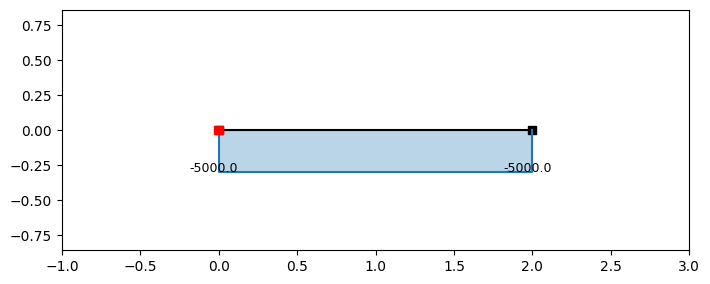

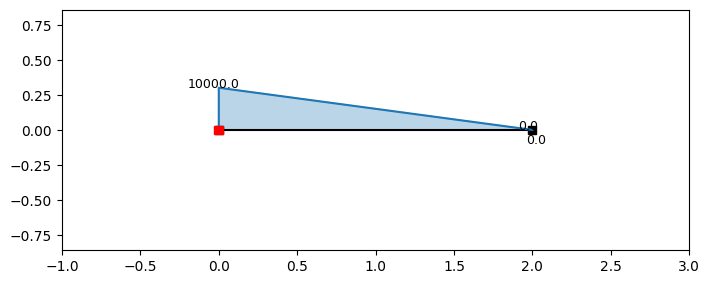

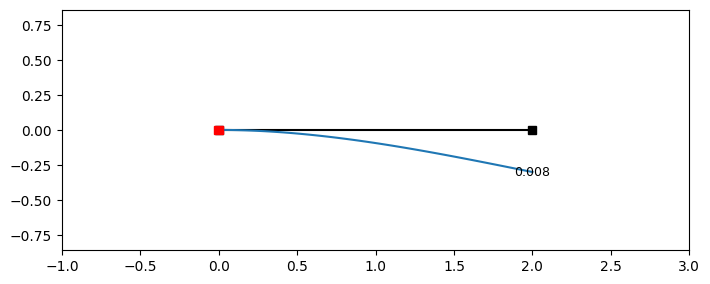

In [5]:
!pip -q install anastruct

from anastruct import SystemElements

L = 2.0     # m
E = 210e9   # Pa
I = 8e-6    # m^4
P = 5e3     # N (dolů)

# EA nepotřebujeme (osa x), dáme velké číslo, EI dáme skutečné
ss = SystemElements(EA=1e12, EI=E*I, figsize=(7,3))

# Prvek 1: od (0,0) do (L,0)
ss.add_element(location=[[0, 0], [L, 0]])

# Vetknutí na uzlu 1
ss.add_support_fixed(node_id=1)

# Bodová síla na volném konci (uzel 2)
ss.point_load(node_id=2, Fy=-P)

# Výpočet
ss.solve()

# Vizualizace: střižná síla, ohybový moment, deformace
ss.show_shear_force()       # V-diagram
ss.show_bending_moment()    # M-diagram
ss.show_displacement()      # průhyb (tvar)

In [6]:
import jax, jax.numpy as jnp

def f(x):
    return jnp.sin(x) * jnp.exp(-x**2)

df = jax.grad(lambda x: f(x).sum())
f_jit = jax.jit(f)

x = jnp.linspace(-3, 3, 1000)
val = f_jit(x).sum()
grad0 = df(x)

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00


In [4]:
import qiskit
print(qiskit.__version__)

2.2.2
